In [1]:
# default_exp optim_w_augment_3
%load_ext autoreload
%autoreload 2

# Optimising With Augmentation: Run 3 With Multiple OCR Models

> Optimisation the whole alphabet using different OCR models and with augmented renderings for `OCRLoss`.

In [2]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.fontsampler import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
from PIL.ImageOps import invert
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Font Learner Factory

In [3]:
#export
def get_learner(
    ocr_fn: str,
    ocr_arch = cornet_for_ocr,
    n_out = 26,
    seed = 42, 
    use_ocr_tfms = True,
    use_translate = True,
    tfms_p = 1.,
    bs: int = None,
    blur_random_size: Tuple[int, Sequence[int]] = 5,
    blur_sigma = (.1, 5),
    noise = 0.,
    **kwargs
    ) -> VectorLearner:
    gc.collect()
    ocr_model = load_ocr_model(file=ocr_fn, arch=ocr_arch, n_out=n_out)
    cb = DebugCB(vocal=False)
    ocr_tfms = []
    if ocr_arch is cornet_for_ocr:
        ocr_tfms += [Pad((48 - 28) // 2, fill=1.),
                     ToRGB(),
                     # DebugTfm("After Pad"),
                     get_imagenet_norm()]
    if use_ocr_tfms:
        # These are the same ones as used for the OCR model
        # max_rotate = 15.0
        # max_warp = .25
        # size = 28
        # tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
        #                       min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=tfms_p, 
        #                       p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
        #                       pad_mode='reflection', align_corners=True, batch=False, 
        #                       min_scale=1.0)
        # warp = tfms[0]
        # ocr_tfms = [warp, blur]
        # if tfms_set == "default":  ocr_tfms += noise
        if use_translate: ocr_tfms += [TranslateAndPad(p=tfms_p)]
        ocr_tfms += [GaussianBlur(p=tfms_p, sigma=blur_sigma, random_size=blur_random_size)]
        if noise: ocr_tfms += [Noise(p=tfms_p, f=(0., noise))]
    learner = create_font_learner(ocr_tfms=ocr_tfms if len(ocr_tfms) else None,
                                letters=None,
                                cbs=cb,
                                ocr_model=ocr_model,
                                n_colors_out=1,
                                lr=1e-1, 
                                init_range=2.,
                                seed=seed,
                                bs=bs,
                                **kwargs)
    if use_ocr_tfms: assert len(learner.loss_func.ocr_loss.tfms) == len(ocr_tfms)
    return learner

## Optimisation Utilities

Copied from `05_full_aphabet_optimisation.ipynb`. 

In [4]:
DUMP_FOLDER = Path("results/test_nb12_augmented")

class ParamRecorderCB(Callback):
    best: dict = None
    best_on = None
    last_best_loss = None
    results: list[dict] = []
    def __init__(self, 
        max_epochs_after_best: int = None, 
        *args, **kwargs
        ):
        super(ParamRecorderCB, self).__init__(*args, **kwargs)
        store_attr("max_epochs_after_best")
    def before_fit(self):
        self.best_on = 0
        if self.best is None: self.last_best_loss = self.get_current_loss()
    def after_loss(self):
        if not self.training: return
        l  = self.loss.item()
        lr = self.opt.hypers[-1]["lr"]
        p  = self.get_param_dict()
        if not self.best or l < self.best["loss"]:
            self.best = dict(loss=l, lr=l, params=p)
            self.best_on = self.epoch
        elif self.max_epochs_after_best is not None and \
             self.epoch - self.best_on > self.max_epochs_after_best:
            raise CancelFitException()
    def after_fit(self):
        impr = self.last_best_loss - self.best["loss"]
        self.last_best_loss = self.best["loss"]
        impr_fr = impr / (self.last_best_loss + EPS)
        self.results.append(dict(impr=impr, 
                                 impr_fr=impr_fr,
                                 stopped_at=self.epoch,
                                 n_epochs=self.n_epoch,
                                 **self.best))
        print(f"Improvement {impr:.4f} ({impr_fr:.2%})")
    def reset_to_best(self):
        """Reset to the best saved parameters."""
        assert self.best
        self.load_param_dict(self.best["params"])

def plot_variation_results(
    variations: list[dict],
    figsize = (6, 6),
    lim: float = None
    ) -> None:
    """Plot the results from `fancy_fit_2_variations`."""
    df = DataFrame(variations)
    if lim is None: lim = math.ceil(max(df.init_loss)) 
    init_med, final_med = np.median(df.init_loss), np.median(df.final_loss)
    impr_med = np.median((df.init_loss - df.final_loss) / df.init_loss)
    min_loss = df.final_loss.min()
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    ax.set_xlim(0, lim), ax.set_ylim(0, lim)
    ax.scatter(df.init_loss, df.final_loss)
    ax.scatter(init_med, final_med)
    plt.suptitle(f"Initial losses vs final losses\n(median in orange, median improvement {impr_med:.2%},\nmin loss {min_loss:.4f})")
    plt.xlabel(f"Initial loss"), plt.ylabel(f"Final loss")

def show_variation_renders(
    variations: Union[list[dict], DataFrame],
    n = 12,
    n_cols = 4,
    fig_width = 14,
    incl_tfms = False,
    learner: VectorLearner = None,
    rerender = False
    ) -> plt.Figure:
    """Show the rendered images together with losses, possibly paired with loss-function-transformed images."""
    if incl_tfms and "img_with_tfms" not in variations[0]:
        assert learner is not None, "You must supply a learner if incl_tfms is True and variations don't contain img_with_tfms."
    assert not rerender or learner, "You must supply a learner if rerender is True"
    if type(variations) is list: variations = DataFrame(variations)
    variations = variations.sort_values(by="final_loss").reset_index()
    n_imgs = n if n is not None and len(variations) > n else len(variations)
    if incl_tfms: n_imgs *= 2
    n_rows = math.ceil(n_imgs / n_cols)
    _img = variations.iloc[0].img
    img_ratio = _img.height / _img.width
    fig_height = (fig_width / n_cols * img_ratio + .5) * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axs = axs.flatten()
    def _do_rend(v, apply_tfms=False):
        return learner.load_param_dict(v.final_params).render_letters(apply_tfms=apply_tfms)
    for i, ax in enumerate(axs):
        if i >= n_imgs: break
        is_tfmd = incl_tfms and i % 2 == 1
        v = variations.iloc[i//2 if incl_tfms else i]
        if is_tfmd: img = v.img_with_tfms if not rerender and "img_with_tfms" in v else _do_rend(v, True)
        else:       img = v.img if not rerender else _do_rend(v)
        ax.imshow(img)
        ax.set_title("With loss tfms" if is_tfmd else f"Loss {v.final_loss:.4f}")
    title = "Rendered fonts and losses"
    if incl_tfms: title += "\nwith examples of loss-function-transformed images\n(Note that true transforms may be randomised)"
    fig.suptitle(title)
    plt.show()
    return fig

def avg_loss(
    learner,
    n = 20,
    return_list = False
    ) -> float:
    """Calc avg loss over `n` iterations."""
    losses = []
    for i in range(n): losses.append(learner.get_current_loss())
    return losses if return_list else sum(losses) / n

def print_losses(
    losses: Union[list, np.array], 
    msg = None
    ) -> dict:
    """Print basic stats of losses."""
    if msg is not None: msg += ": "
    losses = np.array(losses)
    l_mean = losses.mean()
    l_std = losses.std()
    l_spread = losses.max() - losses.min()
    print(f"{msg}Mean: {l_mean:.4f} • SD: {l_std:.4f} ({l_std / l_mean:.1%}) • Spread {l_spread:.4f} ({l_spread / l_mean:.1%})")
    return(dict(mean=l_mean, std=l_std, spread=l_spread))

def get_individual_losses(
    learner,
    iters = 20
    ) -> np.array:
    """Get losses for individual letters. Mean over `iters`."""
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   tfms=learner.loss_func.ocr_loss.tfms, reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    losses = {k.item(): [] for k in y}
    for i in range(iters):
        v = learner.model(x)
        ll = loss(v, y)
        for k, l in zip(y, ll[0]): losses[k.item()].append(l.item())
    losses_list = [losses[k] if k in losses else [-1.] for k in range(len(learner.vocab))]
    means = [np.array(l).mean() for l in losses_list]
    return np.array(means)

def plot_current_individual_losses(
    learner,
    **kwargs
    ) -> np.array:
    means = get_individual_losses(learner, **kwargs)
    letters = learner.vocab
    fig = plt.figure()
    ax = fig.add_subplot()
    line, = ax.plot(means)
    ax.set_xticks(range(len(letters)), labels=letters)
    return means

def try_params(
    learner,
    param = "Width, HNU",
    steps = 40,
    min = -4., max = 4., 
    loss_iters = 20
    ) -> DataFrame:
    """Try different param values and record individual letters losses (mean overs `loss_iters`)."""
    assert steps > 1
    self = learner
    lf = self.loss_func
    with debug(lf):
        model = self.model
        stats = []
        for i in range(steps):
            report("Trying params", prog = i / steps)
            v = min + (max - min) * i / (steps - 1)
            model.set_param(param, v)
            means = {f"loss_{k}": v for k, v in zip(learner.vocab, get_individual_losses(learner, iters=loss_iters))}
            d = {
                "value": model.get_param(param).item(), # There's a discrepancy between v and this
                "interpolated_value": model.get_param_value(param).item(),
                **means
                }
            stats.append(d)
    return DataFrame(stats)

def create_or_load_variations(fn: str,
    plot = True,
    **fancy_fit_args
    ) -> list[dict]:
    """Shortcut for `fancy_fit_ocr_variations` that saves the results. If there 
       already are results saved with `fn`, loads them instead."""
    fp = os.path.join(DUMP_FOLDER, fn)
    try: res = load(fp)
    except: 
        res = fancy_fit_ocr_variations(**fancy_fit_args, filename=fn)
        dump(res, fp)
    if plot: plot_variation_results(res, lim=4)
    return res

def apply_best_params(learner,
    variations: list
    ) -> VectorLearner:
    "Apply the params with the lowest loss from variations to learner."
    best = sorted(variations, key=lambda x: x["final_loss"])[0]
    learner.load_param_dict(best["final_params"])
    return learner

def fancy_fit_ocr_variations(ocr_fn: str,
    fn_suffix = "",
    variations = 20,
    dump_folder = DUMP_FOLDER,
    ocr_arch = cornet_for_ocr,
    n_out = 26,
    seed = 42, 
    use_ocr_tfms = True,
    tfms_p = 1.,
    bs = None,
    zero_width = False,
    blur_random_size: Tuple[int, Sequence[int]] = 5,
    blur_sigma = (.1, 5),
    noise = 0.,
    show_sample = False,
    **kwargs
    ) -> list[dict]:
    """Create variations using `fancy_fit_ocr`."""
    fn = f"font__{Path(ocr_fn).with_suffix('')}{fn_suffix}"
    path = os.path.join(dump_folder, fn)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(ocr_fn, ocr_arch=ocr_arch, n_out=n_out, seed=None, 
                           use_ocr_tfms=use_ocr_tfms, tfms_p=tfms_p, bs=bs,
                           blur_sigma=blur_sigma,
                           blur_random_size=blur_random_size, noise=noise)
        self.reset_parameters()
        if show_sample: display(self.render_letters(apply_tfms=True))
        if zero_width:
            for p in self.param_names:
                if p.startswith("Width"): self.set_param(p, 0.)
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        report(f"Starting variation {k + 1}/{variations}")
        with self.no_progress(): var_res = fancy_fit_ocr(self, msg=f"Variation {k + 1}/{variations} • ", **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            "img_with_tfms":  self.render_letters(apply_tfms=True)
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_ocr(learner: VectorLearner,
    epochs = 25, # 40
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    auto_lr = None,
    iters = 4, # 20
    abort_if = 0.75,
    abort_at = 1, # 2
    max_init_loss = 3., # N/A
    max_reinits = 100,  # N/A
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    if max_init_loss is not None:
        j = 0
        while orig_loss > max_init_loss:
            if j >= max_reinits: 
                report("Max reinits exceeded")
                return [dict(lr=lr,
                        loss=orig_loss,
                        params=learner.get_param_dict(),
                        note="Max reinits exceeded")]
            j += 1
            learner.reset_parameters()
            orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        if auto_lr is not None: lr = getattr(learner.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False), 
                                             auto_lr, lr)
        elif i != 0: lr *= lr_factor
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict()))
        if i >= abort_at and l > abort_if * orig_loss: break
        epochs += epoch_increment
    # clear()
    return res

## Other Utilities

In [5]:
def get_learner_for_fit_letters(calc_loss = False
    ) -> Union[VectorLearner, Tuple[float, VectorLearner]]:
    "Shortcut for getting a learner for tests in this experiment."
    gc.collect()
    learner_args = dict(version = "aug", 
                        use_ocr_tfms = True,
                        tfms_p = 1.,
                        tfms_set = "xstrong",
                        bs = 4 * len(VOCAB_UC))
    learner = get_learner(seed = 42, **learner_args)
    fn_exp5 = "variations_exp5_xstrong_aug"
    fp_exp5 = os.path.join(DUMP_FOLDER, fn_exp5)
    res_exp5 = load(fp_exp5)
    apply_best_params(learner, res_exp5)
    if calc_loss:
        init_loss = learner.get_current_loss(iters=10)
        print(f"Init loss: {init_loss}")
        return init_loss, learner
    else: return learner

def get_font_ocr_loss(
    learner: VectorLearner,
    fn: str = "Arial.ttf",
    folder: Path = SYS_FONT_PATH,
    size_range = (0.5, 1.0),
    steps = 20
    ) -> List[dict]:
    """Find the optimal size for the font and display the OCR loss for that."""
    assert steps > 1
    font_path = folder/fn
    vocab = learner.vocab
    m = learner.model
    w,h = m.canvas_width,m.canvas_height
    lf = learner.loss_func.ocr_loss
    with eval_model(m): x,y = list(learner.dls.train)[0]
    res = []
    sizes = set([round(h * (size_range[0] + i * (size_range[1] - size_range[0]) / (steps - 1))) for i in range(steps)])
    for size in sizes:
        imgs = []
        for x_i in x:
            l = vocab[x_i]
            imgs.append(render_text(font_path, text=l, text_size=size, image_width=w, image_height=h, as_normalised_array=True))
        img_t = concat_tensors(imgs).reshape(-1, 1, w, h)
        loss = lf(img_t, y).item()
        res.append(dict(size=size, loss=loss, imgs=imgs, imgs_tfmd=lf.apply_tfms(img_t)))
    res.sort(key=lambda x: x["loss"])
    print(f"Best loss for {fn}: {res[0]['loss']:.4f} at size {res[0]['size']:d}")
    return res

def show_renders_and_target(learner: VectorLearner,
    grid_scale = .5
    ) -> None:
    """Show rendered letters and target letters."""
    pred = learner.render_letters(grid_scale=grid_scale)
    targ = image_grid(learner.loss_func.target_letters, scale=grid_scale).convert('L')
    size = targ.size
    targ2 = Image.new('RGB', size=size, color="white")
    targ2.paste((255,0,0), mask=invert(targ))
    mask = Image.new('L', size=size, color=128)
    comp = Image.composite(pred, targ2, mask)
    grid_size = (3 * size[0], size[1])
    grid = Image.new('RGB', size=grid_size, color="white")
    for i,img in enumerate([comp, pred, targ]): grid.paste(img, box=(i * size[0], 0))
    print(f"Loss: {learner.get_current_loss()}")
    display(grid)

def plot_variation_losses(variations: list[dict],
    figsize = (10, 10),
    y_range: Tuple[float, float] = None
    ) -> None:
    """Plot the loss trajectories from `fancy_fit_2/3_variations`."""
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    if y_range: ax.set_ylim(*y_range)
    for v in variations:
        res = v["full_res"]
        losses = [v["init_loss"]] + [o["loss"] for o in res]
        ax.plot(range(len(res) + 1), losses)
    plt.xticks(range(1 + max([len(v["full_res"]) for v in variations])))
    plt.xlabel(f"Iterations completed")
    plt.ylabel(f"Loss")

def plot_loss_stats(losses: dict,
    subtitle = "",
    title = "Loss means, stds and ranges for different OCR models",
    figsize = (10,6)
    ) -> Tuple:
    if type(list(losses.values())[0][0]) is not float: losses = all_res_to_loss_dict(losses)
    x = [Path(o).stem.split("_")[-1] for o in losses.keys()]
    y = np.array(list(losses.values()))
    mins  = y.min(1)
    maxes = y.max(1)
    means = y.mean(1)
    std   = y.std(1)
    plt.figure(figsize=figsize)
    plt.errorbar(x, means, std, fmt='ok', lw=3)
    plt.errorbar(x, means, [means - mins, maxes - means],
                 fmt='.k', ecolor='gray', lw=1)
    plt.xlim(-1, len(x))
    plt.suptitle(f"{title}: {subtitle}" if subtitle != "" else title)
    return means,std,mins,maxes

def all_res_to_loss_dict(all_res: dict) -> dict:
    losses = {}
    for k,v in all_res.items(): losses[k] = [o["final_loss"] for o in v]
    return losses

def render_grids(
    imgs,
    folder,
    name = "iter",
    grid_name = "grid",
    pad = (48 - 28)//2
    ) -> None:
    from PIL.ImageOps import expand
    batch_i = -1
    buffer = []
    for f in imgs:
        i = int(Path(f).stem.split("_")[1])
        if i != batch_i:
            if len(buffer): image_grid(buffer).convert('L').save(f"{folder}/{grid_name}_{name}_{batch_i}.png")
            batch_i = i
            buffer = []
        img = Image.open(f)
        buffer.append(img if pad is None else expand(img, pad, fill="white"))

## Common variables

In [6]:
cornet_files = [
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_iter1.pth",
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_iter2.pth",
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_iter3.pth",
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_iter4.pth",
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_iter5.pth",
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds.pth",
    "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur.pth"
]

## Todo

* Test https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html as optim instead of Adam
* Make font optims with augmented CorNET as well (both aug and wo)
* Look at the results from the experiments

## 5. Interlude 2: Generate Animation With Tweaked Adam

Make another animation, this time with Adam having less momentum and with less random augmentations.

In [7]:
fn_suffix = "_exp1f_fullds_blur_lbfgs"
iter_folder = DUMP_FOLDER / "interlude2"
ocr_fn = cornet_files[-1]
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
print(str(iter_folder))
learn = get_learner(ocr_fn, 
                    seed=None, 
                    bs=len(VOCAB_UC),
                    blur_sigma=(4.5, 5.), 
                    blur_random_size=(13,15),
                    folder=str(iter_folder),
                    save_ocr_imgs=True,
                    use_translate=False,
                    mom=0.8,
                    sqr_mom=0.995)
# learn.render_letters(apply_tfms=True)

results/test_nb12_augmented/interlude2


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2688: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:659: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


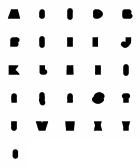

In [16]:
learn.reset_parameters()
learn.render_letters(apply_tfms=False)

In [17]:
learn.cbs[-1].vals = []
learn.model.batch_i = learn.loss_func.ocr_loss.batch_i = -1

In [18]:
learn.fit(100, 1e-1)

epoch,train_loss,valid_loss,time
0,3.399199,3.369322,00:02
1,3.387020,3.296330,00:02
2,3.342763,3.256911,00:02
3,3.323607,3.079002,00:02
4,3.276250,2.975989,00:02
5,3.244834,2.883577,00:02
6,3.195208,2.886078,00:02
7,3.131939,2.787519,00:02
8,3.068486,2.494375,00:02
9,3.025861,2.525030,00:02


In [19]:
learn.fit(50, 5e-2)

epoch,train_loss,valid_loss,time
0,0.645107,0.623845,00:02
1,0.612436,0.590726,00:01
2,0.623972,0.658841,00:01
3,0.612464,0.551414,00:01
4,0.608088,0.646112,00:01
5,0.616940,0.598177,00:01
6,0.605622,0.730057,00:01
7,0.602312,0.595041,00:01
8,0.600183,0.548351,00:01
9,0.594442,0.547681,00:02


In [20]:
learn.fit(50, 2e-2)

epoch,train_loss,valid_loss,time
0,0.572624,0.587910,00:02
1,0.580221,0.588754,00:02
2,0.612431,0.579090,00:01
3,0.623210,0.689244,00:01
4,0.617280,0.546026,00:01
5,0.604041,0.545857,00:01
6,0.593848,0.652914,00:02
7,0.600647,0.635780,00:02
8,0.612333,0.588571,00:01
9,0.615391,0.573377,00:01


Render svgs/hires pngs for each epoch.

First, create a learner with no ImageSavers.

In [7]:
fn_suffix = "_exp1f_fullds_blur_lbfgs"
iter_folder = DUMP_FOLDER / "interlude2"
ocr_fn = cornet_files[-1]
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
learn = get_learner(ocr_fn, 
                    seed=None, 
                    bs=len(VOCAB_UC),
                    blur_sigma=(4.5, 5.), 
                    blur_random_size=(13,15),
                    use_translate=False,
                    mom=0.8,
                    sqr_mom=0.995)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2725: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:678: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Load params.

In [8]:
# params = learn.cbs[-1].vals
# dump(params, f"{fp}_params")
params = load(f"{fp}_params")

Save svgs.

In [13]:
letter = "K"
for i,pset in enumerate(params):
    if i % 25 == 0: print(f"Iter {i}")
    for j,v in enumerate(pset):
        learn.model.set_param(j, v.item())
    fn = DUMP_FOLDER / "svg" / f"font__{Path(ocr_fn).stem}{fn_suffix}_svg_{letter}_{i}"
    learn.save_svg(fn, letter=letter)

Iter 0
Iter 25
Iter 50
Iter 75
Iter 100
Iter 125
Iter 150
Iter 175


Deprecated: Render slowly as hires png's.

In [20]:
learn.model.canvas_height = learn.model.canvas_width = 512
letter = "A"
for i,pset in enumerate(params):
    if i % 10 == 0: print(f"Iter {i}")
    for j,v in enumerate(pset):
        learn.model.set_param(j, v.item())
    img = learn.render_letter(letter)
    fn = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}_hires_{letter}_{i}.png"
    img.save(fn)

Iter 0
Iter 10
Iter 20
Iter 30
Iter 40
Iter 50
Iter 60
Iter 70
Iter 80
Iter 90
Iter 100
Iter 110
Iter 120
Iter 130
Iter 140
Iter 150
Iter 160
Iter 170
Iter 180
Iter 190


Render grids.

In [12]:
img_dir = DUMP_FOLDER/"interlude2"
files = os.listdir(img_dir)
img_list = [o for o in files if o.startswith("iter_")]
aug_list = [o for o in files if o.startswith("augmented_")]
img_list.sort()
aug_list.sort(key=get_file_sorter())
img_list = [str(img_dir/o) for o in img_list]
aug_list = [str(img_dir/o) for o in aug_list]

# learn.image_saver.iter_files = img_list
# learn.loss_func.ocr_loss.image_saver.iter_files = aug_list
# learn.image_saver.render_grids()
# learn.loss_func.ocr_loss.image_saver.render_grids()

render_grids(img_list, DUMP_FOLDER/"interlude2")
render_grids(aug_list, DUMP_FOLDER/"interlude2", grid_name="augmented", pad=None)

## 4. Interlude: Generate Animation for the Website

Render a quick optimisation animation for the website.

results/test_nb12_augmented/interlude


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2698: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:670: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


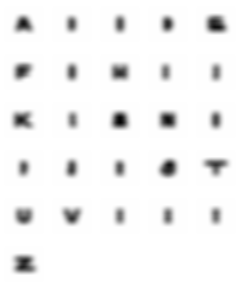

In [8]:
fn_suffix = "_exp1f_fullds_blur"
iter_folder = DUMP_FOLDER / "interlude"
ocr_fn = cornet_files[-1]
fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
print(str(iter_folder))
learn = get_learner(ocr_fn, 
                    seed=None, 
                    bs=len(VOCAB_UC),
                    blur_sigma=(3., 5.), 
                    blur_random_size=(9,15),
                    folder=str(iter_folder),
                    save_ocr_imgs=True,
                    use_translate=False)
learn.render_letters(apply_tfms=True)

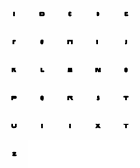

In [33]:
learn.reset_parameters()
learn.render_letters(apply_tfms=False)

In [34]:
learn.model.batch_i = -1

In [35]:
lr = 1e-1
learn.fit(25, lr)

epoch,train_loss,valid_loss,time
0,3.394911,3.383450,00:02
1,3.393960,3.400355,00:02
2,3.391826,3.403744,00:02
3,3.392099,3.357400,00:02
4,3.385553,3.395336,00:02
5,3.385685,3.385157,00:02
6,3.386139,3.354153,00:02
7,3.379336,3.384449,00:02
8,3.375611,3.295950,00:02
9,3.370051,3.289090,00:02


49


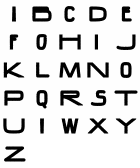

In [37]:
batch_i = learn.model.batch_i; print(batch_i)
learn.render_letters(apply_tfms=False)

In [38]:
learn.model.batch_i = batch_i
lr = 8e-2
learn.fit(25, lr)

epoch,train_loss,valid_loss,time
0,1.583333,1.103733,00:02
1,1.398595,1.398807,00:02
2,1.311712,1.038171,00:01
3,1.228159,1.054956,00:02
4,1.204694,0.995514,00:02
5,1.193095,0.920752,00:02
6,1.156702,1.014133,00:02
7,1.147289,0.925603,00:02
8,1.116648,0.972468,00:02
9,1.094557,0.963165,00:01


In [39]:
lr = 6e-2
learn.fit(25, lr)

epoch,train_loss,valid_loss,time
0,0.488932,1.108302,00:02
1,0.540200,0.853332,00:02
2,0.515237,0.595872,00:02
3,0.587427,0.550949,00:02
4,0.577319,0.552834,00:02
5,0.562360,0.592046,00:02
6,0.564446,0.500781,00:02
7,0.554702,0.516582,00:02
8,0.570208,0.518352,00:02
9,0.573651,0.563561,00:02


In [40]:
lr = 6e-2
learn.fit(25, lr)

epoch,train_loss,valid_loss,time
0,0.527021,0.479844,00:02
1,0.508717,0.508937,00:01
2,0.484138,0.610665,00:01
3,0.472469,0.656581,00:01
4,0.464813,0.625619,00:01
5,0.499313,0.674891,00:02
6,0.498821,0.839339,00:02
7,0.497295,0.446127,00:02
8,0.505746,0.431112,00:01
9,0.503870,0.441083,00:01


Now we seem to have reached convergence. Let's save the params and create grid images.

In [42]:
# params = learn.get_param_dict()
# dump(params, str(fp))
params = load(str(fp))

In [9]:
img_dir = DUMP_FOLDER/"interlude"
files = os.listdir(img_dir)
img_list = [o for o in files if o.startswith("iter_")]
aug_list = [o for o in files if o.startswith("augmented_")]
img_list.sort()
aug_list.sort(key=get_file_sorter())
img_list = [str(img_dir/o) for o in img_list]
aug_list = [str(img_dir/o) for o in aug_list]
aug_list[0:20]



['results/test_nb12_augmented/interlude/augmented_52__0.png',
 'results/test_nb12_augmented/interlude/augmented_52__1.png',
 'results/test_nb12_augmented/interlude/augmented_52__2.png',
 'results/test_nb12_augmented/interlude/augmented_52__3.png',
 'results/test_nb12_augmented/interlude/augmented_52__4.png',
 'results/test_nb12_augmented/interlude/augmented_52__5.png',
 'results/test_nb12_augmented/interlude/augmented_52__6.png',
 'results/test_nb12_augmented/interlude/augmented_52__7.png',
 'results/test_nb12_augmented/interlude/augmented_52__8.png',
 'results/test_nb12_augmented/interlude/augmented_52__9.png',
 'results/test_nb12_augmented/interlude/augmented_52__10.png',
 'results/test_nb12_augmented/interlude/augmented_52__11.png',
 'results/test_nb12_augmented/interlude/augmented_52__12.png',
 'results/test_nb12_augmented/interlude/augmented_52__13.png',
 'results/test_nb12_augmented/interlude/augmented_52__14.png',
 'results/test_nb12_augmented/interlude/augmented_52__15.png',
 '

In [72]:
# img_list = learn.image_saver.iter_files
# aug_list = learn.loss_func.ocr_loss.image_saver.iter_files
# dump(img_list, str(fp) + 'img_list')
# dump(aug_list, str(fp) + 'aug_list')
# learn.image_saver.iter_files = load(str(fp) + 'img_list')
# learn.loss_func.ocr_loss.image_saver.iter_files = load(str(fp) + 'aug_list')

img_dir = DUMP_FOLDER/"interlude"
files = os.listdir(img_dir)
img_list = [o for o in files if o.startswith("iter_")]
aug_list = [o for o in files if o.startswith("augmented_")]
img_list.sort()
aug_list.sort(key=get_file_sorter())
img_list = [str(img_dir/o) for o in img_list]
aug_list = [str(img_dir/o) for o in aug_list]

learn.image_saver.iter_files = img_list
learn.loss_func.ocr_loss.image_saver.iter_files = aug_list
learn.image_saver.render_grids()
learn.loss_func.ocr_loss.image_saver.render_grids()

Rendered batch -1 of set iter
Rendered batch 0 of set iter
Rendered batch 100 of set iter
Rendered batch 101 of set iter
Rendered batch 102 of set iter
Rendered batch 103 of set iter
Rendered batch 104 of set iter
Rendered batch 105 of set iter
Rendered batch 106 of set iter
Rendered batch 107 of set iter
Rendered batch 108 of set iter
Rendered batch 109 of set iter
Rendered batch 10 of set iter
Rendered batch 110 of set iter
Rendered batch 111 of set iter
Rendered batch 112 of set iter
Rendered batch 113 of set iter
Rendered batch 114 of set iter
Rendered batch 115 of set iter
Rendered batch 116 of set iter
Rendered batch 117 of set iter
Rendered batch 118 of set iter
Rendered batch 119 of set iter
Rendered batch 11 of set iter
Rendered batch 120 of set iter
Rendered batch 121 of set iter
Rendered batch 122 of set iter
Rendered batch 123 of set iter
Rendered batch 124 of set iter
Rendered batch 125 of set iter
Rendered batch 126 of set iter
Rendered batch 127 of set iter
Rendered batc

Render the clean images so that they are padded to the same size as the augmented ones.

In [43]:
def render_grids(
    imgs,
    folder,
    name = "iter",
    grid_name = "grid",
    ) -> None:
    from PIL.ImageOps import expand
    batch_i = -1
    buffer = []
    for f in imgs:
        i = int(Path(f).stem.split("_")[1])
        if i != batch_i:
            if len(buffer): image_grid(buffer).convert('L').save(f"{folder}/{grid_name}_{name}_{batch_i}.png")
            batch_i = i
            buffer = []
        buffer.append(expand(Image.open(f), (48 - 28)//2, fill="white"))

render_grids(img_list, DUMP_FOLDER/"interlude")

## 3. Experiment 1 Rerun 4: CorNET With No Augmentation

For comparison to rerun 3, let's have a look at the results if we use no augmantation at all (except padding to match the same size).

In [13]:
fn_suffix = "_exp1e_noaug"
all_res = {}

for ocr_fn in cornet_files:
    fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
    res = try_load(fp)
    if res is None:
        res = fancy_fit_ocr_variations(ocr_fn,
                                    fn_suffix=fn_suffix,
                                    variations=10,
                                    # bs=4 * len(VOCAB_UC),
                                    use_ocr_tfms=False,
                                    epochs=25,
                                    iters=4,
                                    lr=1e-1,
                                    lr_factor=0.9,
                                    # auto_lr="steep",
                                    max_init_loss=3.,
                                    show_sample=True)
        show_variation_renders(res, n=4, incl_tfms=True)
        # plot_variation_results(res)
    all_res[ocr_fn] = res

print(len(all_res))

7


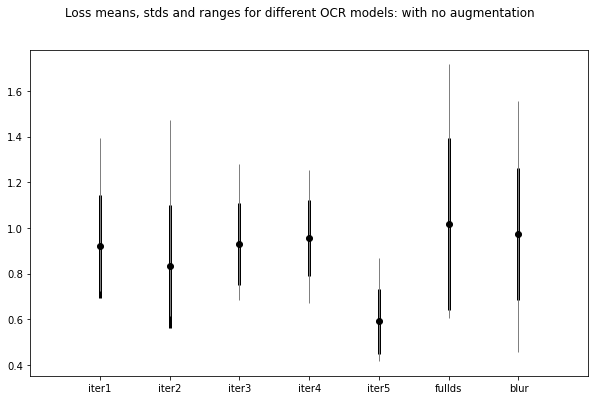

In [14]:
stats = plot_loss_stats(all_res, subtitle="with no augmentation")

## 2. Expreriment 1 Rerun 3: CorNET With Heavy Augmentations

In [11]:
fn_suffix = "_exp1d"
all_res = {}

for ocr_fn in cornet_files:
    fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
    res = try_load(fp)
    if res is None:
        res = fancy_fit_ocr_variations(ocr_fn,
                                    fn_suffix=fn_suffix,
                                    variations=10,
                                    # bs=len(VOCAB_UC),
                                    blur_sigma=(3., 5.), 
                                    blur_random_size=(9,15),
                                    epochs=25,
                                    iters=4,
                                    lr=1e-1,
                                    lr_factor=0.9,
                                    max_init_loss=3.)
        show_variation_renders(res, n=4, incl_tfms=True)
        plot_variation_results(res)
    all_res[ocr_fn] = res

print(len(all_res))

7


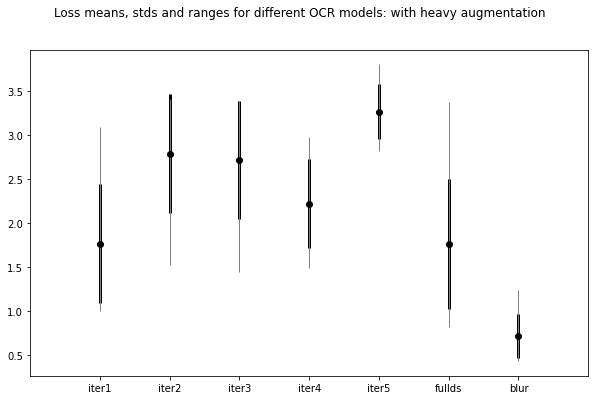

In [12]:
stats = plot_loss_stats(all_res, subtitle="with heavy augmentation")

## 1. Experiment 1 Rerun 2: Optimise With Strong Impairment and Diffrenet OCR Models

> Optimise with different OCR models to see if they produce different results.

Train the models.

In [10]:
fn_suffix = "_exp1c"
all_res = {}

for ocr_fn in cornet_files:
    fp = DUMP_FOLDER / f"font__{Path(ocr_fn).stem}{fn_suffix}all"
    res = try_load(fp)
    if res is None:
        res = fancy_fit_ocr_variations(ocr_fn,
                                    fn_suffix=fn_suffix,
                                    variations=20,
                                    bs=4 * len(VOCAB_UC),
                                    max_init_loss=1.25)
        show_variation_renders(res, n=8, incl_tfms=True)
        plot_variation_results(res)
    all_res[ocr_fn] = res

print(len(all_res))

6


Analyse results. Let's look at the loss trajectories.

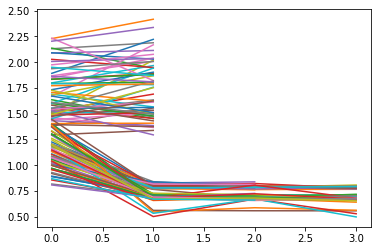

In [11]:
losses = []
for ocr_fn,res in all_res.items():
    for r in res:
        losses.append([r["init_loss"]] + [o["loss"] for o in r["full_res"]])
        # print(r["init_loss"], [o["loss"] for o in r["full_res"]])

for l in losses:
    plt.plot(l)

It looks like there's something silly going on with these. Let's retrain with one model and see what happens.

1.2076665163040161


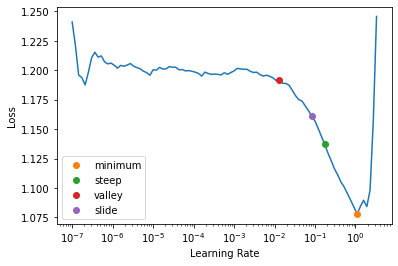

In [9]:
ocr_fn = cornet_files[0]
learn = get_learner(ocr_fn, bs=4 * len(VOCAB_UC))
clear()
learn.reset_parameters()
orig_loss = learn.get_current_loss()
print(orig_loss)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [15]:
p0 = learn.get_param_dict()

In [16]:
learn.load_param_dict(p0)
lr = 0.17378008365631104
epochs = 10
learn.fit(epochs, lr)

epoch,train_loss,valid_loss,time
0,1.160367,1.007370,00:07
1,1.079760,0.952827,00:07
2,1.031869,0.884998,00:07
3,0.993837,0.861684,00:07
4,0.966911,0.850847,00:07
5,0.946889,0.843402,00:07
6,0.941289,0.849860,00:07
7,0.927668,0.849848,00:07
8,0.915892,0.826486,00:08
9,0.908150,0.818195,00:10


In [17]:
learn.load_param_dict(p0)
lr = 0.17378008365631104
epochs = 20
learn.fit(epochs, lr)

epoch,train_loss,valid_loss,time
0,1.188807,0.994553,00:08
1,1.083842,0.930574,00:07
2,1.052874,0.895314,00:07
3,1.010504,0.863166,00:07
4,0.986926,0.875868,00:07
5,0.963442,0.862646,00:07
6,0.946500,0.843423,00:07
7,0.933839,0.849728,00:07
8,0.921635,0.866578,00:07
9,0.914870,0.833638,00:07


In [18]:
learn.load_param_dict(p0)
lr = 0.17378008365631104
epochs = 40
learn.fit(epochs, lr)

epoch,train_loss,valid_loss,time
0,1.167599,0.999171,00:07
1,1.089506,0.924384,00:07
2,1.031274,0.887163,00:07
3,0.991139,0.851579,00:07
4,0.968223,0.862190,00:07
5,0.949201,0.851503,00:07
6,0.933412,0.854659,00:07
7,0.921358,0.841883,00:07
8,0.912552,0.834256,00:07
9,0.903597,0.833564,00:07


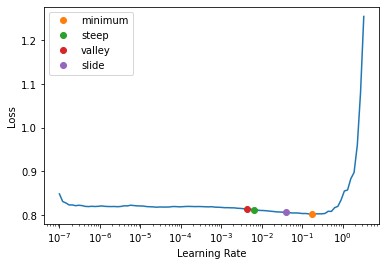

In [19]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

Let's see if there's any improvement to be had by training more.

In [24]:
epochs = 20
lr = 0.0063095735386013985
learn.fit(epochs, lr)

epoch,train_loss,valid_loss,time
0,0.783774,0.789867,00:07
1,0.798394,0.778711,00:07
2,0.797927,0.779075,00:07
3,0.794561,0.811426,00:07
4,0.797282,0.780168,00:07
5,0.794839,0.804111,00:07
6,0.793939,0.779556,00:07
7,0.791624,0.784989,00:07
8,0.790963,0.773605,00:07
9,0.789402,0.803740,00:07


It seems that the steep lr (0.17378008365631104) is fine, and no more than 20-30 epochs are needed, with possibly another 10 epochs with the new steep lr (0.0063095735386013985).

Let's now test what happens with an OCR model that generates the greatest losses (see graph below).

1.3642289638519287


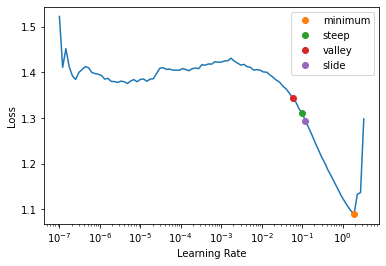

In [25]:
ocr_fn = cornet_files[-2]
learn = get_learner(ocr_fn, bs=4 * len(VOCAB_UC))
clear()
learn.reset_parameters()
orig_loss = learn.get_current_loss()
print(orig_loss)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [26]:
p0 = learn.get_param_dict()

In [27]:
learn.load_param_dict(p0)
lr = lrs.steep
print(lr)
epochs = 25
learn.fit(epochs, lr)

0.10000000149011612


epoch,train_loss,valid_loss,time
0,1.381081,1.091093,00:07
1,1.332993,0.980678,00:07
2,1.265599,0.835361,00:07
3,1.178365,0.795656,00:07
4,1.100890,0.749683,00:07
5,1.033053,0.691038,00:07
6,0.980976,0.824377,00:07
7,0.934928,0.744875,00:07
8,0.914503,0.727379,00:07
9,0.887594,0.632826,00:07


1.0964781722577754e-06


epoch,train_loss,valid_loss,time
0,0.580311,0.566281,00:07
1,0.568812,0.554124,00:07
2,0.564858,0.552131,00:07
3,0.566973,0.596281,00:07
4,0.570229,0.600048,00:07
5,0.575341,0.547077,00:07
6,0.568974,0.532792,00:07
7,0.565726,0.565459,00:07
8,0.563913,0.610084,00:07
9,0.563774,0.652773,00:07


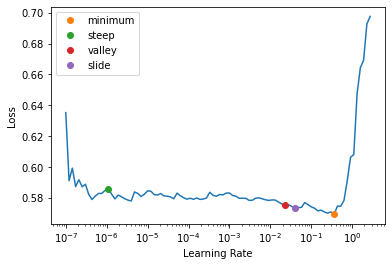

In [30]:
p1 = learn.get_param_dict()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
lr = lrs.steep
print(lr)
epochs = 25
learn.fit(epochs, lr)

In [32]:
learn.load_param_dict(p1)
lr = .075
print(lr)
epochs = 15
learn.fit(epochs, lr)

0.075


epoch,train_loss,valid_loss,time
0,0.564008,0.548970,00:07
1,0.555589,0.524973,00:10
2,0.551364,0.569225,00:07
3,0.561933,0.532821,00:07
4,0.585254,0.554451,00:07
5,0.575074,0.591639,00:07
6,0.568884,0.575809,00:07
7,0.581551,0.573918,15:00
8,0.572087,0.522565,00:08
9,0.571430,0.530330,00:08


### Looking at OCR model losses

Some stats on all of the models we have.

In [13]:
losses = {}
loss_iters = 40
for i,ocr_fn in enumerate(cornet_files):
    learn = get_learner(ocr_fn, bs=4 * len(VOCAB_UC))
    clear()
    print(f"{i}/{len(cornet_files)}")
    ll = []
    for _ in range(loss_iters):
        learn.reset_parameters()
        ll.append(learn.get_current_loss())
    losses[ocr_fn] = np.array(ll)

5/6


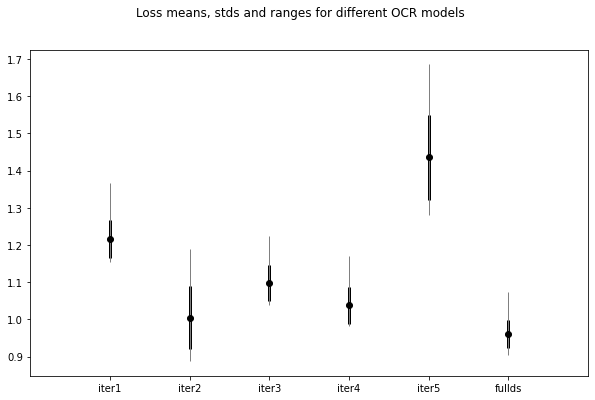

In [20]:
stats = plot_loss_stats(losses)

In [12]:
test = None
for ocr_fn,res in all_res.items():
    for r in res:
        if (l := r["init_loss"]) > 2.:
            test = (l, ocr_fn, r["initial_params"])
            break
print("Init loss", test[0])
learn = get_learner(test[1], bs=4 * len(VOCAB_UC))
learn.load_param_dict(test[2])
loss = learn.get_current_loss()
print("Current loss", loss)

Init loss 2.0073368549346924
GETding OCR model: models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_iter5.pth                              
yes


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2639: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:617: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Current loss 1.9776355028152466


## Export

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
